# RESULTS DVS Gesture

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named Quadro RTX 5000


## Loading of the dataset for the clustering phase

In [10]:
kfold_test = None
kfold_clust = 10
ts_batch_size = 1000

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_False
Read metadata from disk.
number of samples in the training set: 1077
number of samples in the testing set: 264


## Initialization of the network

In [11]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'gesture'

Rz = [4, 8]
N_neuronz = [16, 32]
tauz = [5e4*2, 5e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

## Unsupervised clustering

In [12]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)

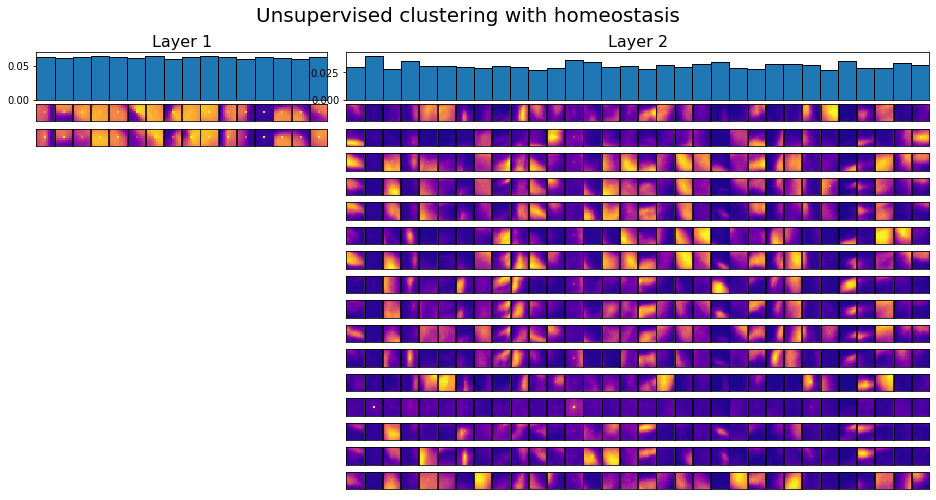

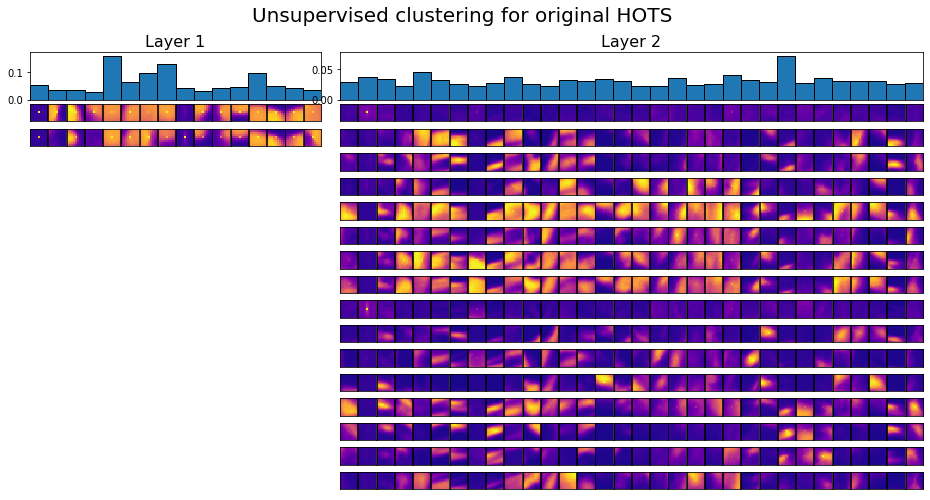

In [13]:
hots.plotlayers();
hots_nohomeo.plotlayers();

## Training of the classification layer

In [6]:
jitter = (None, None)

hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=False, verbose=False)

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
hots_nohomeo.coding(testloader, testset.ordering, testset.classes, filtering_threshold = filtering_threshold, training=False, jitter=jitter, verbose=False)

  0%|                                                                                                                                                       | 0/1077 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
num_workers = 0
learning_rate = 0.0001
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e5
drop_proba = .9

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, testset.ordering, testset.classes, training=False, verbose=False)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size)

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

In [ ]:
train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 4-(b))

In [ ]:
likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering,  ts_batch_size = ts_batch_size)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

In [10]:
print(score, score_nohomeo)

0.7613636363636364 0.6297029702970297


In [12]:
mlr_threshold = None
meanac, onlinac, lastac, best_probability = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)

Number of chance decisions: 0
90th quantile for number of events: 123356.50000000007
Mean accuracy: 14.799999999999999%
Last accuracy: 18.2%
Highest probability accuracy: 18.2%


In [13]:
mlr_threshold = .99
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)

Number of chance decisions: 234
90th quantile for number of events: 123356.50000000007
Mean accuracy: 11.200000000000001%
Last accuracy: 16.3%
Highest probability accuracy: 18.2%


ValueError: too many values to unpack (expected 3)

## Robustness to spatial jitter (Figure 5-(b)-(up))

In [ ]:
import copy
def run_jitter(min_jitter, max_jitter, jitter_type, hots, hots_nohomeo, dataset_name, trainset_output, filtering_threshold = None, kfold = None, nb_trials = 10, nb_points = 20, fitting = True, figure_name = None, verbose = False):
    
    initial_name = copy.copy(hots.name)
    initial_name_nohomeo = copy.copy(hots_nohomeo.name)
    
    n_classes = len(trainset_output.classes)
    n_output_neurons = len(hots.layers[-1].cumhisto)
    ts_size = [trainset_output.sensor_size[0],trainset_output.sensor_size[1],n_output_neurons]
    
    ts_batch_size = None
    mlr_threshold = .99
    type_transform = tonic.transforms.NumpyAsType(int)
    
    if not os.path.exists('../Records/jitter_results/'):
        os.mkdir('../Records/jitter_results/')
    if jitter_type=='temporal':
        std_jit_t = np.logspace(min_jitter,max_jitter,nb_points)
        jitter_values = std_jit_t
    else:
        std_jit_s = np.linspace(min_jitter,max_jitter,nb_points)
        var_jit_s = std_jit_s**2
        jitter_values = var_jit_s

    jitter_path = f'../Records/jitter_results/{initial_name}_{nb_trials}_{min_jitter}_{max_jitter}_{kfold}_{nb_points}'

    if not os.path.exists(jitter_path+'.npz'):

        torch.set_default_tensor_type("torch.DoubleTensor")

        for trial in tqdm(range(nb_trials)):
            for ind_jit, jitter_val in enumerate(jitter_values):
                if jitter_val==0:
                    jitter = (None,None)
                else:
                    if jitter_type=='temporal':
                        jitter = (None,jitter_val)
                    else:
                        jitter = (jitter_val,None)
                        
                hots.name = initial_name+f'_{trial}'
                hots_nohomeo.name = initial_name_nohomeo+f'_{trial}'
                
                drop_proba = .5

                if jitter_type=='temporal':
                    temporal_jitter_transform = tonic.transforms.TimeJitter(std = jitter_val, clip_negative = True, sort_timestamps = True)
                    transform_full = tonic.transforms.Compose([temporal_jitter_transform, type_transform])
                    if drop_proba:
                        drop_transform = tonic.transforms.DropEvent(p = drop_proba)
                        transform_full = tonic.transforms.Compose([drop_transform, temporal_jitter_transform, type_transform])
                else:
                    spatial_jitter_transform = tonic.transforms.SpatialJitter(sensor_size = trainset_output.sensor_size, variance_x = jitter_val, variance_y = jitter_val, clip_outliers = True)
                    transform_full = tonic.transforms.Compose([spatial_jitter_transform, type_transform])
                    if drop_proba:
                        drop_transform = tonic.transforms.DropEvent(p = drop_proba)
                        transform_full = tonic.transforms.Compose([drop_transform, spatial_jitter_transform, type_transform])
                    
                if dataset_name=='poker':
                    testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform_full)
                    testloader = get_loader(testset, kfold = kfold)
                elif dataset_name=='nmnist':
                    testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=transform_full)
                    testloader = get_loader(testset, kfold = kfold)
                elif dataset_name=='gesture':
                    testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=transform_full)
                    testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold)
                    
                num_sample_test = len(testloader)
                test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
                test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'
                    
                print(test_path)
                
                hots.coding(testloader, trainset_output.ordering, testset.classes, training=False, jitter = jitter, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size, verbose=False)
                hots_nohomeo.coding(testloader, trainset_output.ordering, testset.classes, training=False, jitter=jitter, filtering_threshold=filtering_threshold, ts_batch_size = ts_batch_size, verbose=False)
                
                testset_output = HOTS_Dataset(test_path, trainset_output.sensor_size, trainset_output.classes, dtype=trainset_output.dtype, transform=type_transform)
                test_outputloader = get_loader(testset_output, shuffle=False)
                
                testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset_output.sensor_size, trainset_output.classes, dtype=trainset_output.dtype, transform=type_transform)
                test_outputloader_nohomeo = get_loader(testset_output_nohomeo, shuffle=False)
                
                print(len(test_outputloader), len(test_outputloader_nohomeo))
                
                likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,test_outputloader,results_path,ts_size, testset_output.ordering)
                meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, verbose=False)

                histo_score = make_histogram_classification(trainset_output, testset_output, n_output_neurons)
                histo_score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, n_output_neurons)
                
                print(f'Accuracy for jitter {jitter}:')
                print(f'online HOTS -> {meanac*100} % - {lastac*100} %')
                print(f'histogram score: {histo_score_nohomeo*100} % - homeo {histo_score*100} %')

In [ ]:
kfold_jitter = 2
nb_trials = 10
nb_points = 10

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]

trainset_output_jitter = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
run_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, dataset_name, trainset_output_jitter, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, filtering_threshold = filtering_threshold, fitting = False);

## Robustness to temporal jitter (Figure 5-(b)-(down))

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
run_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, dataset_name, trainset_output_jitter, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, filtering_threshold = filtering_threshold, fitting = False)